In [1]:
import os
import sys

os.environ["PYSPARK_PYTHON"]="C:\Spark\spark-3.3.2-bin-hadoop2\python"
os.environ["JAVA_HOME"] = "C:\Program Files\Java\jdk-18.0.2.1"
os.environ["SPARK_HOME"] = "C:\Spark\spark-3.3.2-bin-hadoop2"
os.environ["PYLIB"] = os.environ["SPARK_HOME"] + "/python/lib"
sys.path.insert(0, os.environ["PYLIB"] + "/py4j-0.10.9.5-src.zip")
sys.path.insert(0, os.environ["PYLIB"] + "/pyspark.zip")

MAX_MEMORY = "14G"
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("direct_predict") \
    .config("spark.driver.memory", MAX_MEMORY) \
    .getOrCreate()    
spark

In [2]:
import pandas as pd

pd.set_option('display.max_columns', None)

In [4]:
model_data = spark.read.option("header","true").option("inferSchema","true").csv("../data/EDA/final_data_for_modelling.csv")
model_data = model_data.drop("_c0")
model_data.printSchema()
model_data.count()

root
 |-- age_imputed: double (nullable = true)
 |-- bg2_lactate_imputed: double (nullable = true)
 |-- basophils_imputed: double (nullable = true)
 |-- eosinophils_imputed: double (nullable = true)
 |-- lymphocytes_imputed: double (nullable = true)
 |-- monocytes_imputed: double (nullable = true)
 |-- neutrophils_imputed: double (nullable = true)
 |-- albumin_imputed: double (nullable = true)
 |-- aniongap_imputed: double (nullable = true)
 |-- bicarbonate_imputed: double (nullable = true)
 |-- bun_imputed: double (nullable = true)
 |-- calcium_imputed: double (nullable = true)
 |-- chloride_imputed: double (nullable = true)
 |-- creatinine_imputed: double (nullable = true)
 |-- glucose_imputed: double (nullable = true)
 |-- sodium_imputed: double (nullable = true)
 |-- potassium_imputed: double (nullable = true)
 |-- inr_imputed: double (nullable = true)
 |-- pt_imputed: double (nullable = true)
 |-- ptt_imputed: double (nullable = true)
 |-- hematocrit_imputed: double (nullable = tr

63887

In [5]:
# Splitting the data into train and test (Remember you are expected to compare the model later)
train, test = model_data.randomSplit([0.7,0.3])
print("Size of training data {0}".format(train.count()))
print("Size of test data {0}".format(test.count()))

Size of training data 44472
Size of test data 19415


In [9]:
# data transfo
feature_cols =  model_data.columns
feature_cols.remove("charlson_comorbidity_index_imputed")
feature_cols.remove("gender")
feature_cols.append("gender_imputed")
print(feature_cols)

categorical_cols = ["gender"]
print(categorical_cols)


['age_imputed', 'bg2_lactate_imputed', 'basophils_imputed', 'eosinophils_imputed', 'lymphocytes_imputed', 'monocytes_imputed', 'neutrophils_imputed', 'albumin_imputed', 'aniongap_imputed', 'bicarbonate_imputed', 'bun_imputed', 'calcium_imputed', 'chloride_imputed', 'creatinine_imputed', 'glucose_imputed', 'sodium_imputed', 'potassium_imputed', 'inr_imputed', 'pt_imputed', 'ptt_imputed', 'hematocrit_imputed', 'hemoglobin_imputed', 'mch_imputed', 'mchc_imputed', 'mcv_imputed', 'platelet_imputed', 'rbc_imputed', 'rdw_imputed', 'wbc_imputed', 'scr_min_imputed', 'ckd_imputed', 'mdrd_est_imputed', 'scr_baseline_imputed', 'alt_imputed', 'alp_imputed', 'ast_imputed', 'bilirubin_total_imputed', 'gender_imputed']
['gender']


In [12]:
# model train
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler

si = StringIndexer(inputCols=categorical_cols, outputCols=[c+'_idx' for c in categorical_cols], handleInvalid="keep")
ohe = OneHotEncoder(inputCols=[c+'_idx' for c in categorical_cols], outputCols=[c+'_imputed' for c in categorical_cols], handleInvalid="keep")
assembler = VectorAssembler( inputCols = feature_cols, outputCol = 'features')
scaler = StandardScaler( inputCol = 'features', outputCol = 'standardized')
lr = LinearRegression( featuresCol="standardized", labelCol="charlson_comorbidity_index_imputed")


pipeline =  Pipeline(stages = [si, ohe, assembler, scaler, lr])
model = pipeline.fit(train)

# save model
model.write().overwrite().save("../model/direct_predict_model.pkl")

In [21]:
## training data
predictionoutput = model.transform(train)
y_test = predictionoutput.select("charlson_comorbidity_index_imputed").toPandas()
y_test_pred = predictionoutput.select("prediction").toPandas()


import sklearn.metrics as sm
print("Mean absolute error =", round(sm.mean_absolute_error(y_test, y_test_pred), 2)) 
print("Mean squared error =", round(sm.mean_squared_error(y_test, y_test_pred), 2)) 
print("Median absolute error =", round(sm.median_absolute_error(y_test, y_test_pred), 2)) 
print("Explain variance score =", round(sm.explained_variance_score(y_test, y_test_pred), 2)) 
print("R2 score =", round(sm.r2_score(y_test, y_test_pred), 2))

Mean absolute error = 1.13
Mean squared error = 2.6
Median absolute error = 0.85
Explain variance score = 0.59
R2 score = 0.59


In [22]:
## test data
predictionoutput = model.transform(test)
y_test = predictionoutput.select("charlson_comorbidity_index_imputed").toPandas()
y_test_pred = predictionoutput.select("prediction").toPandas()


import sklearn.metrics as sm
print("Mean absolute error =", round(sm.mean_absolute_error(y_test, y_test_pred), 2)) 
print("Mean squared error =", round(sm.mean_squared_error(y_test, y_test_pred), 2)) 
print("Median absolute error =", round(sm.median_absolute_error(y_test, y_test_pred), 2)) 
print("Explain variance score =", round(sm.explained_variance_score(y_test, y_test_pred), 2)) 
print("R2 score =", round(sm.r2_score(y_test, y_test_pred), 2))

Mean absolute error = 1.14
Mean squared error = 2.65
Median absolute error = 0.86
Explain variance score = 0.59
R2 score = 0.59


The closer the r-squared value is to 1, the better the fit. 

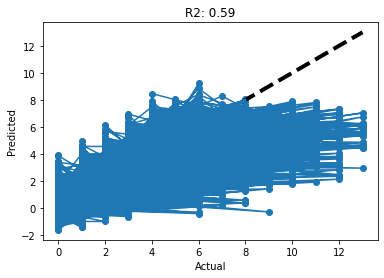

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

fig, ax = plt.subplots()
ax.scatter(y_test, y_test_pred)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')

#y_test.reshape
y_test_1, y_test_pred_1 = y_test.values.reshape(-1,1), y_test_pred.values.reshape(-1,1)
ax.plot(y_test_1, y_test_pred_1)

ax.set_title('R2: ' + str(round(sm.r2_score(y_test, y_test_pred), 2)))
plt.show()